In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

sns.set_style("whitegrid", {'axes.grid' : False})

# from tqdm.notebook import tqdm
from tqdm.auto import tqdm

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [33]:
from dataloader import AgeGroupMLDataset

In [34]:
from encoder_simple import Encoder

In [47]:
from decoder import Decoder

## Train embedding

In [35]:
from pytorch_metric_learning import losses, miners, distances, reducers, samplers

In [45]:
BATCH_SIZE = 64 # BATCH_SIZE unique persons
SAMPLES_PER_CLASS = 1 # drawing 64 classes per batch
NUM_OF_SUBSEQUENCES = 5
SUBSEQUENCE_LENGTH = 90

EMBEDDING_DIM = 256
LR = 0.001
NUM_EPOCHS = 150

In [13]:
dataset = AgeGroupMLDataset()

In [14]:
dataset.load_client_to_indices()

In [37]:
import random

In [38]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [39]:
targets = dataset.targets

In [40]:
sampler = samplers.MPerClassSampler(
    targets, SAMPLES_PER_CLASS, batch_size=BATCH_SIZE,
    length_before_new_iter=BATCH_SIZE * 100) # 100 batches per epoch

In [41]:
dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE,
    num_workers=0,
    sampler=sampler,
)

In [42]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SUBSEQUENCESxSUBSEQUENCE_LENGTHx(num_features)
sequences[0].shape, sequences[1].shape

(torch.Size([64, 5, 90, 5]), torch.Size([64, 5, 90, 1]))

In [44]:
num_input_dim = sequences[0].size(-1)
cat_vocab_sizes = [204]

encoder = Encoder(
    numerical_input_dim=num_input_dim,
    embedding_dim=EMBEDDING_DIM,
    cat_vocab_sizes=cat_vocab_sizes,
    subseq_length=SUBSEQUENCE_LENGTH,
)
encoder.to(device);

In [48]:
LR = 0.003

In [49]:
optimizer = optim.Adam(encoder.parameters(), lr=LR)

In [50]:
distance = distances.CosineSimilarity()
reducer = reducers.ThresholdReducer(low = 0) # basically, returns average
loss_func = losses.TripletMarginLoss(margin = 0.4, distance = distance, reducer = reducer)
mining_func = miners.TripletMarginMiner(margin = 0.4, distance = distance, type_of_triplets = "semihard")

# sota
# loss_func = losses.ArcFaceLoss(
#     num_classes=len(targets), embedding_size=EMBEDDING_DIM,
#     distance=distance).to(torch.device('cuda')) # not sure why we need to move it to cuda

In [53]:
NUM_EPOCHS = 20

In [54]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    encoder.train()
    epoch_losses = []
    for batch_idx, (sequences, labels) in enumerate(dataloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)

        labels = torch.repeat_interleave(labels, NUM_OF_SUBSEQUENCES)
        labels = labels.to(device)

        embeddings = encoder(n, c)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)

    print("Epoch {} Loss = {}".format(epoch, epoch_loss))

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0 Loss = 0.1703004091978073
Epoch 1 Loss = 0.15360534191131592
Epoch 2 Loss = 0.1497141718864441
Epoch 3 Loss = 0.14790457487106323
Epoch 4 Loss = 0.14541131258010864
Epoch 5 Loss = 0.14427340030670166
Epoch 6 Loss = 0.14426112174987793
Epoch 7 Loss = 0.14354082942008972
Epoch 8 Loss = 0.14334672689437866
Epoch 9 Loss = 0.1429678499698639
Epoch 10 Loss = 0.1426268219947815
Epoch 11 Loss = 0.14244885742664337
Epoch 12 Loss = 0.1424523890018463
Epoch 13 Loss = 0.14184804260730743
Epoch 14 Loss = 0.14115217328071594
Epoch 15 Loss = 0.1408321112394333
Epoch 16 Loss = 0.14143751561641693
Epoch 17 Loss = 0.14056383073329926
Epoch 18 Loss = 0.14054273068904877
Epoch 19 Loss = 0.13957564532756805


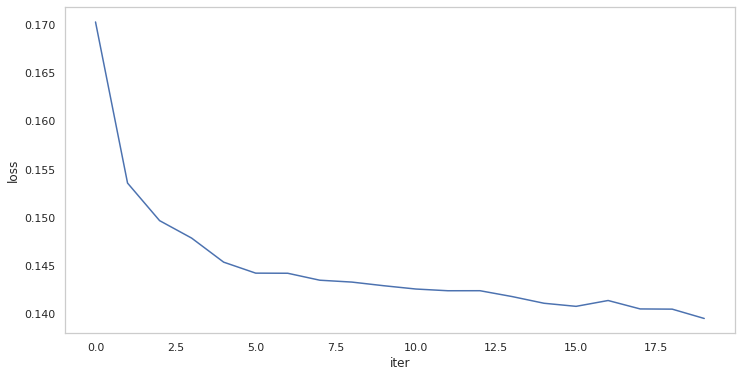

In [55]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.plot(train_losses, label='train')
plt.xlabel('iter')
plt.ylabel('loss');

# Train classifier

In [57]:
from dataloader import AgeGroupClfDataset

In [58]:
# freeze encoder
for param in encoder.parameters():
    param.requires_grad = False

encoder.eval();

In [59]:
clfdataset = AgeGroupClfDataset()

In [60]:
clfdataset.load_client_to_indices()

In [61]:
from sklearn.model_selection import train_test_split

In [79]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [78]:
targets = clfdataset.targets

train_idx, test_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.3,
    shuffle=True,
    stratify=targets,
    random_state=228
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

trainloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=train_sampler)
testloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    sampler=test_sampler)

In [63]:
clfdataloader = torch.utils.data.DataLoader(
    clfdataset, batch_size=BATCH_SIZE,
    num_workers=0,
)

In [64]:
# check
dataiter = iter(clfdataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExSUBSEQUENCE_LENGTHx(num_features)
sequences[0].shape, sequences[1].shape

(torch.Size([64, 90, 5]), torch.Size([64, 90, 1]))

In [65]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [66]:
SCHEDULER_EPOCHS = 2

In [67]:
optimizer = optim.Adam(decoder.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    patience=SCHEDULER_EPOCHS,
)

In [69]:
NUM_EPOCHS = 20

In [74]:
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []

for epoch in tqdm(range(NUM_EPOCHS)):
    decoder.train()
    correct = 0
    epoch_losses = []
    for batch_idx, (sequences, labels) in enumerate(trainloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        embeddings = encoder(n, c)
        outputs = decoder(embeddings)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred_labels = torch.argmax(outputs, dim=1)
        correct += sum(labels == pred_labels)
        epoch_losses.append(loss.item())

    train_acc = correct / (BATCH_SIZE * len(trainloader))
    epoch_loss = torch.tensor(epoch_losses).mean()
    train_losses.append(epoch_loss)
    train_accuracy.append(train_acc.item())

    decoder.eval()
    correct = 0
    epoch_val_losses = []
    for batch_idx, (sequences, labels) in enumerate(testloader):
        n, c = sequences[0], sequences[1]
        n = n.to(device)
        c = c.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            embeddings = encoder(n, c)
            outputs = decoder(embeddings)
            loss = criterion(outputs, labels)
            epoch_val_losses.append(loss.item())

            pred_labels = torch.argmax(outputs, dim=1)
            correct += sum(labels == pred_labels)

    epoch_val_loss = torch.tensor(epoch_val_losses).mean()

    scheduler.step(epoch_val_loss)

    val_losses.append(epoch_val_loss)

    val_acc = correct / (BATCH_SIZE * len(testloader))
    val_accuracy.append(val_acc.item())
    
    print(f'Epoch {epoch}, train acc: {train_acc}, val acc: {val_acc}')
    print(f'train loss: {epoch_loss}; val loss: {epoch_val_loss}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0, train acc: 0.5533814430236816, val acc: 0.5523049235343933
train loss: 0.9873296618461609; val loss: 0.9874230623245239
Epoch 1, train acc: 0.5513867735862732, val acc: 0.5564051270484924
train loss: 0.989396870136261; val loss: 0.979583203792572
Epoch 2, train acc: 0.5517192482948303, val acc: 0.5503102540969849
train loss: 0.9867462515830994; val loss: 0.9818251729011536
Epoch 3, train acc: 0.5509593486785889, val acc: 0.553634762763977
train loss: 0.9869312644004822; val loss: 0.9868937730789185
Epoch 4, train acc: 0.5507218837738037, val acc: 0.5607269406318665
train loss: 0.9900466203689575; val loss: 0.9789926409721375
Epoch 5, train acc: 0.5491071343421936, val acc: 0.5565159320831299
train loss: 0.9913326501846313; val loss: 0.9763230085372925
Epoch 6, train acc: 0.5545212626457214, val acc: 0.551972508430481
train loss: 0.9908255934715271; val loss: 0.9865193367004395
Epoch 7, train acc: 0.5532864928245544, val acc: 0.5607269406318665
train loss: 0.993007481098175; va

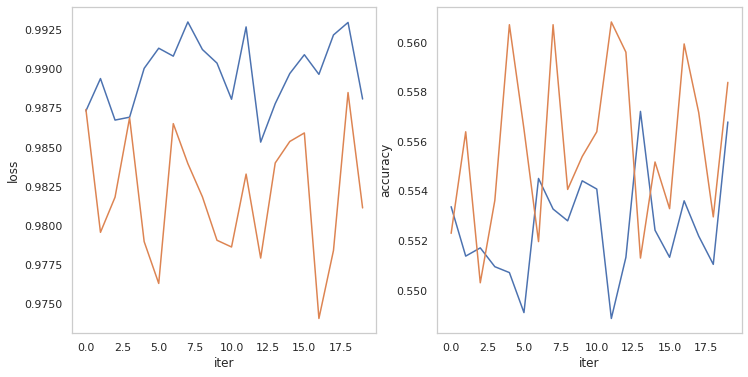

In [77]:
fig, axs = plt.subplots(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='validation')
plt.xlabel('iter')
plt.ylabel('loss')

plt.subplot(1, 2, 2)
plt.xlabel('iter')
plt.plot(train_accuracy, label='train')
plt.plot(val_accuracy, label='validation')
plt.ylabel('accuracy');

# Predict (old)

In [ ]:
m = encoder.to('cpu').eval()

In [ ]:
# check
dataiter = iter(dataloader)
sequences, labels = dataiter.next()

# should be BATCH_SIZExNUM_OF_SEQUNCESxSUBSEQUENCE_LENGTHx(num_features)
sequences.shape

In [ ]:
embeddings = torch.zeros((1, EMBEDDING_DIM))[1:]

# probably can make it faster if use a batch of clients
for client_id in tqdm(sorted(dataset.targets)):
    n, c = dataset.get_sequence(client_id)

    with torch.no_grad():
        embedding = m(n, c)
        # encoded_events = m.event_encoder(n, c)
        # encoded_events = encoded_events.view(1, -1, EMBEDDING_DIM)
        # encoded_events = torch.transpose(encoded_events, 0, 1) # so that its (seq_len, batch, input_size)
        # embedding = m.sequence_encoder(encoded_events)[0][0]
        embeddings = torch.cat((embeddings, embedding))

embeddings.shape

In [ ]:
X = embeddings.numpy()

# y = dataset.target_df[dataset.target_df['client_id'].isin(dataset.clients)].sort_values('client_id')['bins'].to_numpy()

y = dataset.target_df.sort_values('client_id')['bins'].to_numpy()

In [ ]:
decoder = Decoder(input_dim=EMBEDDING_DIM)
decoder.to(device);

In [ ]:
from catboost import CatBoostClassifier, Pool
from catboost import cv
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=228, stratify=y)

train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test, y_test)

In [ ]:
model = CatBoostClassifier(
    iterations=500,
    depth=3,
    learning_rate=0.5,
    verbose=True,
    eval_metric='Accuracy',
    auto_class_weights='Balanced',
    random_state=228,
)

In [ ]:
model.fit(train_pool, eval_set=test_pool)

In [ ]:
train_acc = model.evals_result_['learn']['Accuracy']
valid_acc = model.evals_result_['validation']['Accuracy']

plt.plot(train_acc, label='train')
plt.plot(valid_acc, label='valid')
plt.xlabel('iter')
plt.ylabel('accuracy')
plt.legend();

In [ ]:
sum(np.squeeze(model.predict(X_test)) == y_test) / len(y_test)